# Perbandingan Strategi EMA112 vs VWAP

Notebook ini menjalankan dua strategi rule-based pada data OHLCV ETHUSDT 1 jam.
Fokusnya adalah membandingkan strategi trend-following EMA112 dengan strategi mean-reversion VWAP
sehingga kita bisa cepat melihat karakteristik masing-masing pendekatan.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path
from typing import Mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

if not hasattr(matplotlib.rcParams, '_get'):
    def _rcparams_get(key, default=None):
        return matplotlib.rcParams.get(key, default)
    matplotlib.rcParams._get = _rcparams_get



def locate_project_root() -> Path:
    """Temukan root repository agar path relatif bekerja di mana saja."""

    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if (candidate / 'src').exists() and (candidate / 'data').exists():
            return candidate
    raise RuntimeError("Folder proyek tidak ditemukan dari direktori kerja saat ini.")


PROJECT_ROOT = locate_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.pipelines import (  # noqa: E402  # isort: skip
    IndicatorConfig,
    SingleAssetPipelineConfig,
    run_single_asset_pipeline,
    save_backtest_outputs,
)
from src.performance.metrics import summarise_bar_returns  # noqa: E402  # isort: skip


### Konfigurasi strategi


In [2]:
DATA_PATH = PROJECT_ROOT / 'data' / 'OKX_ETHUSDT.P, 60.csv'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'strategy_comparison'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ML_PREDICTIONS_PATH = PROJECT_ROOT / 'outputs' / 'predictions' / 'lightgbm_ml_baseline_predictions.csv'
SECONDS_IN_YEAR = 365 * 24 * 60 * 60
BARS_PER_DAY = 24.0
BARS_PER_YEAR = BARS_PER_DAY * 365.0

STRATEGY_SETUPS = {
    'ema112': {
        'strategy_name': 'ema112',
        'strategy_kwargs': {
            'ema_length': 112,
            'price_column': 'close',
        },
        'price_column': 'close',
        'horizon_bars': 4000,
        'indicators': [
            {
                'name': 'ema',
                'source_column': 'close',
                'target_column': 'ema_reference',
                'params': {'span': 112},
            }
        ],
        'output_prefix': 'ema112_hourly',
        'save_outputs': True,
    },
    'vwap': {
        'strategy_name': 'vwap',
        'strategy_kwargs': {
            'rsi_length': 14,
            'rsi_overbought': 70,
            'rsi_oversold': 30,
            'atr_length': 14,
            'atr_stop_multiplier': 1.5,
            'session_frequency': '1D',
        },
        'price_column': 'close',
        'horizon_bars': 4000,
        'indicators': [],
        'output_prefix': 'vwap_hourly',
        'save_outputs': True,
    },
}


def estimate_years(index: pd.DatetimeIndex) -> float:
    if not isinstance(index, pd.DatetimeIndex) or len(index) < 2:
        return float('nan')
    elapsed = (index[-1] - index[0]).total_seconds()
    return elapsed / SECONDS_IN_YEAR if elapsed > 0 else float('nan')


def turnover_from_trades(trades: pd.DataFrame, index: pd.DatetimeIndex) -> float:
    years = estimate_years(index)
    if trades is None or trades.empty or not years or years <= 0:
        return float('nan')
    return float(len(trades) / years)


def turnover_from_positions(positions: pd.Series) -> float:
    if positions is None or positions.empty:
        return float('nan')
    years = estimate_years(positions.index)
    if not years or years <= 0:
        return float('nan')
    changes = positions.diff().abs().fillna(0.0)
    return float((changes.sum() / 2.0) / years)


def average_hold_bars(trades: pd.DataFrame | None = None, positions: pd.Series | None = None) -> float:
    if trades is not None and not trades.empty and 'bars_held' in trades.columns:
        return float(trades['bars_held'].mean())
    if positions is None or positions.empty:
        return float('nan')
    mask = positions != 0
    if not mask.any():
        return float('nan')
    groups = mask.ne(mask.shift()).cumsum()
    lengths = mask.groupby(groups).sum()
    lengths = lengths[lengths > 0]
    if lengths.empty:
        return float('nan')
    return float(lengths.mean())


def build_pipeline_config(setup: Mapping[str, object]) -> SingleAssetPipelineConfig:
    indicators = tuple(IndicatorConfig(**item) for item in setup.get('indicators', []))
    data_path = Path(setup.get('data_path', DATA_PATH))
    if not data_path.exists():
        raise FileNotFoundError(f"File data {data_path} tidak ditemukan.")
    return SingleAssetPipelineConfig(
        data_path=str(data_path),
        strategy_name=setup['strategy_name'],
        strategy_kwargs=setup.get('strategy_kwargs', {}),
        horizon_bars=setup.get('horizon_bars'),
        indicators=indicators,
        price_column=setup.get('price_column', 'close'),
    )


def infer_prediction_horizon(index: pd.DatetimeIndex | None) -> pd.Timedelta | None:
    if index is None or not isinstance(index, pd.DatetimeIndex) or len(index) < 2:
        return None
    deltas = index.to_series().diff().dropna()
    if deltas.empty:
        return None
    median_delta = deltas.median()
    return median_delta if pd.notna(median_delta) else None


def _max_streak(mask: pd.Series) -> int:
    streak = 0
    max_streak = 0
    for flag in mask.astype(bool):
        if flag:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak


def summarise_simple_trades(trades: pd.DataFrame, positions: pd.Series | None) -> dict:
    summary: dict[str, float] = {'total_trades': int(len(trades))}
    total_bars = int(len(positions)) if positions is not None else 0
    if total_bars > 0 and positions is not None:
        in_market = int((positions != 0).sum())
        long_bars = int((positions > 0).sum())
        short_bars = int((positions < 0).sum())
        flat_bars = total_bars - in_market
        summary.update(
            {
                'bars_in_market': float(in_market),
                'bars_flat': float(flat_bars),
                'time_in_market_pct': float(in_market / total_bars) if total_bars else float('nan'),
                'flat_time_pct': float(flat_bars / total_bars) if total_bars else float('nan'),
                'long_exposure_pct': float(long_bars / total_bars) if total_bars else float('nan'),
                'short_exposure_pct': float(short_bars / total_bars) if total_bars else float('nan'),
                'avg_position': float(positions.mean()),
                'avg_abs_position': float(positions.abs().mean()),
            }
        )
    else:
        summary.update(
            {
                'bars_in_market': float('nan'),
                'bars_flat': float('nan'),
                'time_in_market_pct': float('nan'),
                'flat_time_pct': float('nan'),
                'long_exposure_pct': float('nan'),
                'short_exposure_pct': float('nan'),
                'avg_position': float('nan'),
                'avg_abs_position': float('nan'),
            }
        )

    if trades.empty:
        summary.update(
            {
                'long_trades': 0,
                'short_trades': 0,
                'winning_trades': 0,
                'losing_trades': 0,
                'breakeven_trades': 0,
                'win_rate': float('nan'),
                'loss_rate': float('nan'),
                'breakeven_rate': float('nan'),
                'avg_pnl_pct': float('nan'),
                'avg_pnl_currency': float('nan'),
                'median_pnl_pct': float('nan'),
                'net_profit_pct': float('nan'),
                'net_profit_currency': float('nan'),
                'gross_profit_pct': float('nan'),
                'gross_loss_pct': float('nan'),
                'gross_profit_currency': float('nan'),
                'gross_loss_currency': float('nan'),
                'profit_factor_pct': float('nan'),
                'profit_factor_currency': float('nan'),
                'avg_win_pct': float('nan'),
                'avg_loss_pct': float('nan'),
                'avg_win_currency': float('nan'),
                'avg_loss_currency': float('nan'),
                'avg_bars': float('nan'),
                'median_bars': float('nan'),
                'avg_bars_winning': float('nan'),
                'avg_bars_losing': float('nan'),
                'max_consecutive_wins': 0.0,
                'max_consecutive_losses': 0.0,
                'long_short_ratio': float('nan'),
                'best_trade_pct': float('nan'),
                'worst_trade_pct': float('nan'),
                'best_trade_currency': float('nan'),
                'worst_trade_currency': float('nan'),
            }
        )
        return summary

    pnl_pct = trades['pnl_pct'].astype(float)
    pnl_currency = trades['pnl_currency'].astype(float)
    bars_held = trades['bars_held'].astype(float)
    long_mask = trades['direction'] == 'Long'
    short_mask = trades['direction'] == 'Short'
    winning_mask = pnl_pct > 0
    losing_mask = pnl_pct < 0
    breakeven_mask = ~(winning_mask | losing_mask)

    wins_pct = pnl_pct[winning_mask]
    losses_pct = pnl_pct[losing_mask]
    wins_cur = pnl_currency[winning_mask]
    losses_cur = pnl_currency[losing_mask]

    gross_profit_pct = float(wins_pct.sum()) if winning_mask.any() else 0.0
    gross_loss_pct = float(-losses_pct.sum()) if losing_mask.any() else 0.0
    gross_profit_currency = float(wins_cur.sum()) if winning_mask.any() else 0.0
    gross_loss_currency = float(-losses_cur.sum()) if losing_mask.any() else 0.0

    summary.update(
        {
            'long_trades': int(long_mask.sum()),
            'short_trades': int(short_mask.sum()),
            'winning_trades': int(winning_mask.sum()),
            'losing_trades': int(losing_mask.sum()),
            'breakeven_trades': int(breakeven_mask.sum()),
            'win_rate': float(winning_mask.mean()),
            'loss_rate': float(losing_mask.mean()),
            'breakeven_rate': float(breakeven_mask.mean()),
            'avg_pnl_pct': float(pnl_pct.mean()),
            'avg_pnl_currency': float(pnl_currency.mean()),
            'median_pnl_pct': float(pnl_pct.median()),
            'net_profit_pct': float(pnl_pct.sum()),
            'net_profit_currency': float(pnl_currency.sum()),
            'gross_profit_pct': gross_profit_pct,
            'gross_loss_pct': gross_loss_pct,
            'gross_profit_currency': gross_profit_currency,
            'gross_loss_currency': gross_loss_currency,
            'profit_factor_pct': gross_profit_pct / gross_loss_pct if gross_loss_pct else float('nan'),
            'profit_factor_currency': gross_profit_currency / gross_loss_currency if gross_loss_currency else float('nan'),
            'avg_win_pct': float(wins_pct.mean()) if winning_mask.any() else float('nan'),
            'avg_loss_pct': float(losses_pct.mean()) if losing_mask.any() else float('nan'),
            'avg_win_currency': float(wins_cur.mean()) if winning_mask.any() else float('nan'),
            'avg_loss_currency': float(losses_cur.mean()) if losing_mask.any() else float('nan'),
            'avg_bars': float(bars_held.mean()),
            'median_bars': float(bars_held.median()),
            'avg_bars_winning': float(bars_held[winning_mask].mean()) if winning_mask.any() else float('nan'),
            'avg_bars_losing': float(bars_held[losing_mask].mean()) if losing_mask.any() else float('nan'),
            'max_consecutive_wins': float(_max_streak(winning_mask)),
            'max_consecutive_losses': float(_max_streak(losing_mask)),
            'long_short_ratio': float(long_mask.sum() / short_mask.sum()) if short_mask.sum() else float('nan'),
            'best_trade_pct': float(pnl_pct.max()),
            'worst_trade_pct': float(pnl_pct.min()),
            'best_trade_currency': float(pnl_currency.max()),
            'worst_trade_currency': float(pnl_currency.min()),
        }
    )
    return summary


def build_ml_trade_frame(predictions: pd.DataFrame) -> pd.DataFrame:
    if predictions is None or predictions.empty:
        return pd.DataFrame(
            columns=[
                'trade_id',
                'direction',
                'entry_time',
                'exit_time',
                'bars_held',
                'position',
                'probability',
                'signal',
                'future_return',
                'pnl_pct',
                'pnl_currency',
                'side_pnl',
                'mae',
                'mfe',
            ]
        )
    trades = predictions.copy()
    required = {'position', 'pnl'}
    missing = required.difference(trades.columns)
    if missing:
        raise KeyError(f"Kolom wajib hilang dari prediksi ML: {sorted(missing)}")
    trades = trades[trades['position'] != 0].copy()
    trades = trades.sort_index()
    trades['trade_id'] = np.arange(1, len(trades) + 1)
    trades['direction'] = np.where(trades['position'] > 0, 'Long', 'Short')
    trades['pnl_pct'] = trades['pnl'].astype(float)
    trades['pnl_currency'] = trades['pnl_pct']
    trades['side_pnl'] = np.where(trades['position'] > 0, trades['pnl_pct'], -trades['pnl_pct'])
    trades['bars_held'] = 1
    trades['mae'] = np.where(trades['pnl_pct'] < 0, trades['pnl_pct'], 0.0)
    trades['mfe'] = np.where(trades['pnl_pct'] > 0, trades['pnl_pct'], 0.0)
    horizon = infer_prediction_horizon(predictions.index)
    trades['entry_time'] = trades.index
    trades['exit_time'] = trades['entry_time'] + horizon if horizon is not None else pd.NaT
    ordered = [
        'trade_id',
        'direction',
        'entry_time',
        'exit_time',
        'bars_held',
        'position',
        'probability',
        'signal',
        'future_return',
        'pnl_pct',
        'pnl_currency',
        'side_pnl',
        'mae',
        'mfe',
    ]
    for column in ordered:
        if column not in trades.columns:
            trades[column] = np.nan
    return trades[ordered + [col for col in trades.columns if col not in ordered]]


### Jalankan backtest EMA112 & VWAP


In [3]:
results = {}

for label, setup in STRATEGY_SETUPS.items():
    print(f"Menjalankan strategi {label}...")
    pipeline_cfg = build_pipeline_config(setup)
    outputs = run_single_asset_pipeline(pipeline_cfg)
    results[label] = outputs

    metrics_df = pd.Series(outputs.metrics, name='value').to_frame()
    trade_summary_df = pd.Series(outputs.trade_summary, name='value').to_frame()

    print(f"Ringkasan metrics ({label}):")
    display(metrics_df.style.format({'value': '{:.4f}'}))

    print(f"Ringkasan trade ({label}):")
    display(trade_summary_df.style.format({'value': '{:.4f}'}))

    if setup.get('save_outputs'):
        prefix = setup.get('output_prefix', label)
        artifacts = save_backtest_outputs(outputs, OUTPUT_DIR, prefix=prefix)
        print('Artifacts tersimpan:')
        for name, artifact_path in artifacts.items():
            print(f"  - {name}: {artifact_path}")


Menjalankan strategi ema112...
Ringkasan metrics (ema112):


,value
total_return,0.2440
cagr,0.6130
sharpe_ratio,1.3394
annualised_vol,0.4240
max_drawdown,-0.2487
avg_drawdown_duration,93.5238


Ringkasan trade (ema112):


,value
total_trades,98.0000
bars_in_market,2082.0000
bars_flat,1918.0000
time_in_market_pct,0.5205
flat_time_pct,0.4795
long_exposure_pct,0.5205
short_exposure_pct,0.0000
avg_position,0.5205
avg_abs_position,0.5205
long_trades,98.0000


Artifacts tersimpan:
  - metrics: C:\Users\jefri\backtest\outputs\strategy_comparison\ema112_hourly_metrics.json
  - trades: C:\Users\jefri\backtest\outputs\strategy_comparison\ema112_hourly_trades.csv
  - plot: C:\Users\jefri\backtest\outputs\strategy_comparison\ema112_hourly_equity.png
Menjalankan strategi vwap...
Ringkasan metrics (vwap):


,value
total_return,0.3061
cagr,0.7948
sharpe_ratio,1.4981
annualised_vol,0.4614
max_drawdown,-0.1482
avg_drawdown_duration,168.6957


Ringkasan trade (vwap):


,value
total_trades,41.0000
bars_in_market,2114.0000
bars_flat,1886.0000
time_in_market_pct,0.5285
flat_time_pct,0.4715
long_exposure_pct,0.2130
short_exposure_pct,0.3155
avg_position,-0.1025
avg_abs_position,0.5285
long_trades,26.0000


Artifacts tersimpan:
  - metrics: C:\Users\jefri\backtest\outputs\strategy_comparison\vwap_hourly_metrics.json
  - trades: C:\Users\jefri\backtest\outputs\strategy_comparison\vwap_hourly_trades.csv
  - plot: C:\Users\jefri\backtest\outputs\strategy_comparison\vwap_hourly_equity.png


### Bandingkan kinerja kedua strategi


In [4]:
ml_predictions = None
ml_equity = None
ml_trades = None
ml_trade_summary = None
ml_metrics: dict[str, float] = {}
if ML_PREDICTIONS_PATH.exists():
    ml_predictions = pd.read_csv(ML_PREDICTIONS_PATH, parse_dates=['time']).set_index('time')
    if 'position' not in ml_predictions.columns:
        signal = ml_predictions.get('signal', pd.Series(0.0, index=ml_predictions.index))
        ml_predictions['position'] = np.sign(signal.fillna(0.0))
    if 'pnl' not in ml_predictions.columns:
        future_ret = ml_predictions.get('future_return', pd.Series(0.0, index=ml_predictions.index))
        ml_predictions['pnl'] = ml_predictions['position'].fillna(0.0) * future_ret.fillna(0.0)

if not results:
    raise RuntimeError('Belum ada hasil backtest untuk dibandingkan.')

label_map = {'ema112': 'EMA112', 'vwap': 'VWAP'}
comparison_records: list[dict[str, object]] = []
overview_rows: list[dict[str, object]] = []
for label, output in results.items():
    strategy_returns = output.results['strategy_return'].fillna(0.0)
    stats = summarise_bar_returns(strategy_returns, bars_per_year=BARS_PER_YEAR)
    record = {'strategy': label}
    record.update(stats)
    comparison_records.append(record)
    overview_rows.append(
        {
            'strategy': label_map.get(label.lower(), label.upper()),
            'total_return': stats['total_return'],
            'cagr': stats['cagr'],
            'annualised_vol': stats['annualised_vol'],
            'sharpe_ratio': stats['sharpe_ratio'],
            'max_drawdown': stats['max_drawdown'],
            'time_in_market_pct': output.trade_summary.get('time_in_market_pct'),
        }
    )

comparison = (
    pd.DataFrame(comparison_records)
    .set_index('strategy')
    .sort_index()
)

if ml_predictions is not None and not ml_predictions.empty:
    ml_returns = ml_predictions['pnl'].fillna(0.0)
    ml_stats = summarise_bar_returns(ml_returns, bars_per_year=BARS_PER_YEAR)
    ml_metrics = ml_stats
    ml_row = pd.Series(ml_stats, name='ml_lightgbm')
    comparison = (
        pd.concat([comparison, ml_row.to_frame().T], axis=0, sort=False)
        .sort_index()
    )

print('Ringkasan metrics head-to-head:')
display(comparison)

overview_columns = [
    'strategy',
    'total_return',
    'cagr',
    'annualised_vol',
    'sharpe_ratio',
    'max_drawdown',
    'time_in_market_pct',
]
strategy_overview = pd.DataFrame(overview_rows, columns=overview_columns).set_index('strategy')
if 'ML' not in strategy_overview.index:
    strategy_overview.loc['ML'] = np.nan
if ml_predictions is not None and not ml_predictions.empty:
    strategy_overview.loc['ML'] = [
        ml_metrics.get('total_return', np.nan),
        ml_metrics.get('cagr', np.nan),
        ml_metrics.get('annualised_vol', np.nan),
        ml_metrics.get('sharpe_ratio', np.nan),
        ml_metrics.get('max_drawdown', np.nan),
        ml_trade_summary.get('time_in_market_pct') if ml_trade_summary else float('nan'),
    ]
desired_order = ['ML', 'EMA112', 'VWAP']
strategy_overview = strategy_overview.reindex(
    desired_order + [idx for idx in strategy_overview.index if idx not in desired_order]
)

print('Strategi utama (ML vs EMA112 vs VWAP):')
display(strategy_overview)

if ml_metrics:
    print('Ringkasan metrics (ml_lightgbm):')
    display(pd.Series(ml_metrics, name='value').to_frame().style.format({'value': '{:.4f}'}))

exposure_payload = {}
for label, output in results.items():
    summary = output.trade_summary
    exposure_payload[label] = {
        'time_in_market_pct': summary.get('time_in_market_pct'),
        'avg_position': summary.get('avg_position'),
        'avg_abs_position': summary.get('avg_abs_position'),
        'total_trades': summary.get('total_trades'),
        'win_rate': summary.get('win_rate'),
        'turnover_per_year': turnover_from_trades(output.trades, output.results.index),
        'avg_hold_bars': average_hold_bars(trades=output.trades),
    }

if ml_predictions is not None and not ml_predictions.empty:
    ml_positions = ml_predictions.get('position', pd.Series(index=ml_predictions.index, dtype=float)).fillna(0.0)
    ml_equity = pd.DataFrame(
        {
            'position': ml_positions,
            'future_return': ml_predictions.get('future_return'),
            'pnl': ml_predictions['pnl'],
            'equity_curve': (1.0 + ml_predictions['pnl'].fillna(0.0)).cumprod(),
        },
        index=ml_predictions.index,
    )
    ml_trades = build_ml_trade_frame(ml_predictions)
    ml_trade_summary = summarise_simple_trades(ml_trades, ml_positions)
    if ml_trade_summary:
        print('Ringkasan trade (ml_lightgbm):')
        display(pd.Series(ml_trade_summary, name='value').to_frame().style.format({'value': '{:.4f}'}))
    exposure_payload['ml_lightgbm'] = {
        'time_in_market_pct': float((ml_positions != 0).mean()),
        'avg_position': float(ml_positions.mean()),
        'avg_abs_position': float(ml_positions.abs().mean()),
        'total_trades': ml_trade_summary.get('total_trades') if ml_trade_summary else float('nan'),
        'win_rate': ml_trade_summary.get('win_rate') if ml_trade_summary else float('nan'),
        'turnover_per_year': turnover_from_positions(ml_positions),
        'avg_hold_bars': average_hold_bars(trades=ml_trades, positions=ml_positions),
    }

exposure = pd.DataFrame(exposure_payload).transpose()
print('Eksposur & jumlah trade:')
display(exposure)


Ringkasan metrics head-to-head:


,total_return,cagr,annualised_vol,sharpe_ratio,max_drawdown,average_return,volatility,hit_rate,n_bars,bars_per_year
ema112,0.243988,0.613241,0.423962,1.339374,-0.248668,0.000065,0.004530,0.259250,4000.0,8760.0
ml_lightgbm,1.197049,8922.774884,1.706333,6.182062,-0.486026,0.001204,0.018231,0.541502,759.0,8760.0
vwap,0.306121,0.795013,0.461393,1.498110,-0.148194,0.000079,0.004930,0.265750,4000.0,8760.0


Strategi utama (ML vs EMA112 vs VWAP):


,total_return,cagr,annualised_vol,sharpe_ratio,max_drawdown,time_in_market_pct
strategy,,,,,,
ML,1.197049,8922.774884,1.706333,6.182062,-0.486026,NaN
EMA112,0.243988,0.613241,0.423962,1.339374,-0.248668,0.5205
VWAP,0.306121,0.795013,0.461393,1.498110,-0.148194,0.5285


Ringkasan metrics (ml_lightgbm):


,value
total_return,1.1970
cagr,8922.7749
annualised_vol,1.7063
sharpe_ratio,6.1821
max_drawdown,-0.4860
average_return,0.0012
volatility,0.0182
hit_rate,0.5415
n_bars,759.0000
bars_per_year,8760.0000


Ringkasan trade (ml_lightgbm):


,value
total_trades,759.0000
bars_in_market,759.0000
bars_flat,0.0000
time_in_market_pct,1.0000
flat_time_pct,0.0000
long_exposure_pct,0.5613
short_exposure_pct,0.4387
avg_position,0.1225
avg_abs_position,1.0000
long_trades,426.0000


Eksposur & jumlah trade:


,time_in_market_pct,avg_position,avg_abs_position,total_trades,win_rate,turnover_per_year,avg_hold_bars
ema112,0.5205,0.52050,0.5205,98.0,0.153061,214.673668,21.244898
vwap,0.5285,-0.10250,0.5285,41.0,0.268293,89.812453,51.560976
ml_lightgbm,1.0000,0.12253,1.0000,759.0,0.541502,2692.717678,1.000000


### Cuplikan trade terbaru


In [5]:
for label, output in results.items():
    print(f"Trade terbaru untuk {label}:")
    tail_trades = output.trades.tail().reset_index(drop=True)
    display(tail_trades)

if ml_trades is not None and not ml_trades.empty:
    print("Trade terbaru untuk ml_lightgbm:")
    display(ml_trades.tail().reset_index(drop=True))
else:
    print("Prediksi ML belum menghasilkan trade untuk ditampilkan.")


Trade terbaru untuk ema112:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,mae,mfe,long_pnl_pct,short_pnl_pct,entry_ema,entry_position,exit_ema,exit_position
0,94,Long,2025-11-08 03:00:00+00:00,2025-11-08 05:00:00+00:00,3451.86,3429.91,-0.006359,-21.95,2,long_exit_signal,-0.006359,0.001321,-0.006359,0.0,3447.127526,1.0,3446.984348,0.0
1,95,Long,2025-11-08 08:00:00+00:00,2025-11-08 09:00:00+00:00,3453.20,3438.21,-0.004341,-14.99,1,long_exit_signal,-0.004341,0.000000,-0.004341,0.0,3447.026402,1.0,3446.870359,0.0
2,96,Long,2025-11-09 12:00:00+00:00,2025-11-11 15:00:00+00:00,3440.20,3479.51,0.011427,39.31,51,long_exit_signal,0.000000,0.056154,0.011427,0.0,3429.204907,1.0,3510.725148,0.0
3,97,Long,2025-11-12 10:00:00+00:00,2025-11-12 15:00:00+00:00,3532.16,3426.73,-0.029849,-105.43,5,long_exit_signal,-0.029849,0.012049,-0.029849,0.0,3493.171500,1.0,3495.373123,0.0
4,98,Long,2025-11-13 05:00:00+00:00,2025-11-13 13:00:00+00:00,3526.79,3436.49,-0.025604,-90.30,8,long_exit_signal,-0.025604,0.003298,-0.025604,0.0,3481.721595,1.0,3484.378093,0.0


Trade terbaru untuk vwap:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,...,entry_atr,entry_active_entry_price,entry_stop_level,entry_position,exit_vwap,exit_rsi,exit_atr,exit_active_entry_price,exit_stop_level,exit_position
0,37,Long,2025-10-24 18:00:00+00:00,2025-10-28 14:00:00+00:00,3909.58,4117.00,0.053054,207.42,92,long_exit_signal,...,41.018442,3909.58,3848.052337,long,4114.500712,48.320503,38.720764,4117.0,4175.081145,short
1,38,Short,2025-10-28 14:00:00+00:00,2025-11-06 11:00:00+00:00,4117.00,3398.00,0.174642,719.00,213,short_exit_signal,...,38.720764,4117.00,4175.081145,short,3399.908738,50.062534,39.751537,3398.0,3338.372694,long
2,39,Long,2025-11-06 11:00:00+00:00,2025-11-06 14:00:00+00:00,3398.00,3327.52,-0.020742,-70.48,3,long_exit_signal,...,39.751537,3398.00,3338.372694,long,3387.104309,39.596225,45.215932,NaN,NaN,flat
3,40,Short,2025-11-07 06:00:00+00:00,2025-11-07 18:00:00+00:00,3346.24,3424.05,-0.023253,-77.81,12,short_exit_signal,...,42.729746,3346.24,3410.334619,short,3303.165248,64.643187,54.045688,NaN,NaN,flat
4,41,Long,2025-11-08 21:00:00+00:00,2025-11-13 16:00:00+00:00,3403.62,3326.10,-0.022776,-77.52,115,long_exit_signal,...,33.878638,3403.62,3352.802043,long,3451.153372,29.437357,51.804053,NaN,NaN,flat


Trade terbaru untuk ml_lightgbm:


,trade_id,direction,entry_time,exit_time,bars_held,position,probability,signal,future_return,pnl_pct,pnl_currency,side_pnl,mae,mfe,pnl
0,755,Long,2025-11-13 17:00:00+00:00,2025-11-13 18:00:00+00:00,1,1.0,0.855791,0.711582,-0.008044,-0.008044,-0.008044,-0.008044,-0.008044,0.000000,-0.008044
1,756,Long,2025-11-13 18:00:00+00:00,2025-11-13 19:00:00+00:00,1,1.0,0.787119,0.574239,0.005602,0.005602,0.005602,0.005602,0.000000,0.005602,0.005602
2,757,Long,2025-11-13 19:00:00+00:00,2025-11-13 20:00:00+00:00,1,1.0,0.589841,0.179683,0.001133,0.001133,0.001133,0.001133,0.000000,0.001133,0.001133
3,758,Long,2025-11-13 20:00:00+00:00,2025-11-13 21:00:00+00:00,1,1.0,0.655092,0.310184,0.011517,0.011517,0.011517,0.011517,0.000000,0.011517,0.011517
4,759,Long,2025-11-13 21:00:00+00:00,2025-11-13 22:00:00+00:00,1,1.0,0.915196,0.830392,0.018564,0.018564,0.018564,0.018564,0.000000,0.018564,0.018564


### Analisis tambahan: distribusi PnL & MAE/MFE


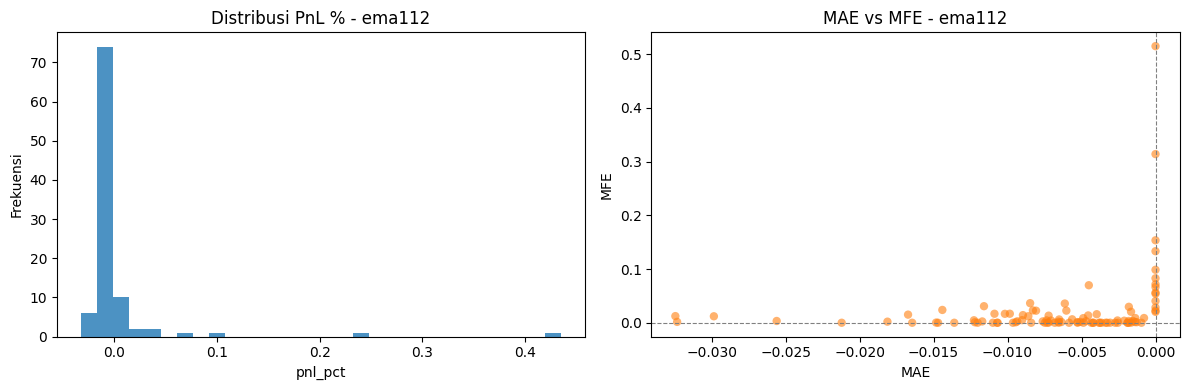

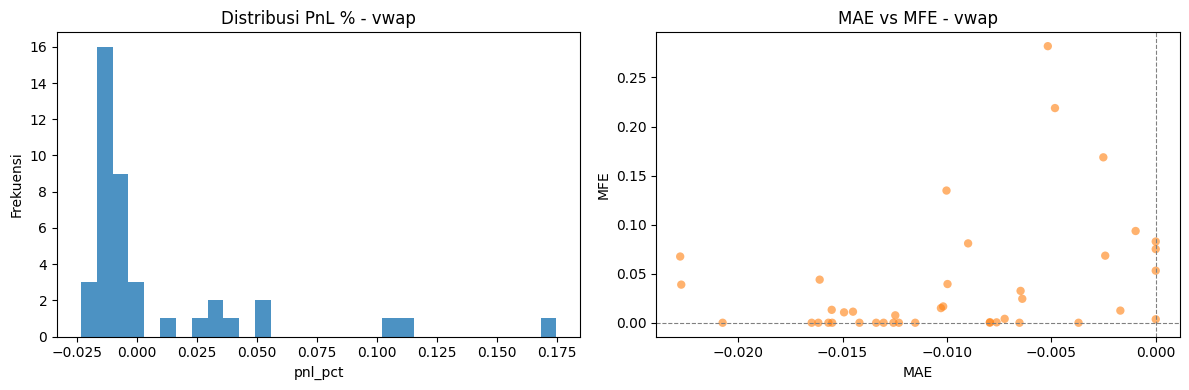

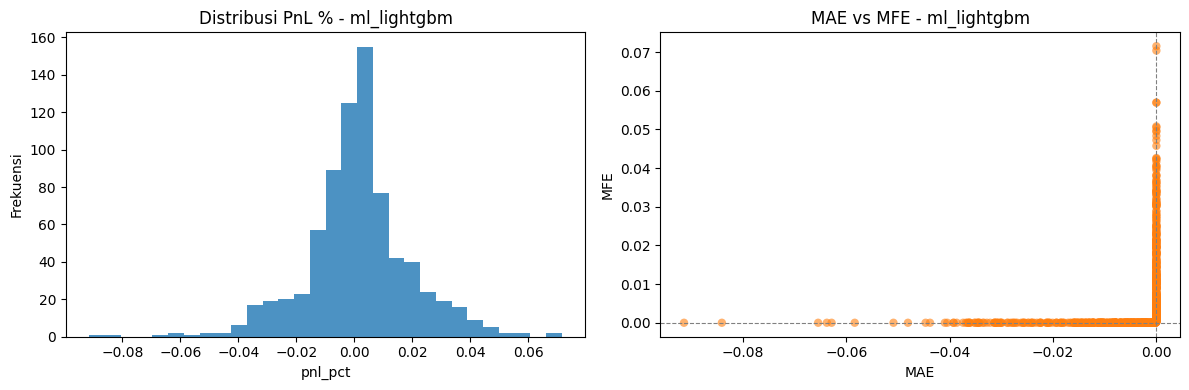

In [6]:
plot_payload = {label: output.trades for label, output in results.items()}
if ml_trades is not None:
    plot_payload['ml_lightgbm'] = ml_trades

for label, trades in plot_payload.items():
    if trades is None or trades.empty:
        print(f'Tidak ada data trade untuk {label}.')
        continue
    pnl = trades.get('pnl_pct')
    if pnl is None:
        print(f'Tidak ada kolom pnl_pct untuk {label}.')
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(pnl.dropna(), bins=30, color='#1f77b4', alpha=0.8)
    axes[0].set_title(f'Distribusi PnL % - {label}')
    axes[0].set_xlabel('pnl_pct')
    axes[0].set_ylabel('Frekuensi')

    mae = trades.get('mae')
    mfe = trades.get('mfe')
    mae_mfe = None
    if mae is not None and mfe is not None:
        mae_mfe = pd.DataFrame({'mae': mae, 'mfe': mfe}).dropna()
    if mae_mfe is not None and not mae_mfe.empty:
        axes[1].scatter(mae_mfe['mae'], mae_mfe['mfe'], alpha=0.6, color='#ff7f0e', edgecolor='none')
    else:
        axes[1].text(0.5, 0.5, 'Tidak ada data MAE/MFE', transform=axes[1].transAxes, ha='center')
    axes[1].set_title(f'MAE vs MFE - {label}')
    axes[1].set_xlabel('MAE')
    axes[1].set_ylabel('MFE')
    axes[1].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    axes[1].axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.show()


In [7]:
import importlib.util
from pathlib import Path
import pandas as pd
from datetime import datetime, timezone
try:
    PROJECT_ROOT
except NameError:  # pragma: no cover - notebook convenience
    PROJECT_ROOT = Path.cwd()



def export_tables_to_excel(tables, path: Path) -> Path:
    def strip_timezone_from_value(value):
        if value is pd.NaT:
            return value
        if isinstance(value, pd.Timestamp):
            if value.tz is not None:
                return value.tz_convert("UTC").tz_localize(None)
            return value
        if isinstance(value, datetime):
            if value.tzinfo is not None:
                return value.astimezone(timezone.utc).replace(tzinfo=None)
            return value
        return value

    def strip_timezone_from_axis(axis):
        if isinstance(axis, pd.MultiIndex):
            new_levels = [strip_timezone_from_axis(level) for level in axis.levels]
            return axis.set_levels(new_levels)
        if isinstance(axis, pd.DatetimeIndex) and axis.tz is not None:
            return axis.tz_convert("UTC").tz_localize(None)
        if getattr(axis, "dtype", None) == object:
            return pd.Index([strip_timezone_from_value(val) for val in axis], name=axis.name)
        return axis

    def make_excel_safe(frame: pd.DataFrame) -> pd.DataFrame:
        frame = frame.copy()
        frame.index = strip_timezone_from_axis(frame.index)
        frame.columns = strip_timezone_from_axis(frame.columns)
        for column in frame.columns:
            series = frame[column]
            if isinstance(series.dtype, pd.DatetimeTZDtype):
                frame[column] = series.dt.tz_convert("UTC").dt.tz_localize(None)
            elif series.dtype == object:
                frame[column] = series.map(strip_timezone_from_value)
        return frame

    serialisable = []
    for sheet_name, table in tables.items():
        if table is None:
            continue
        if isinstance(table, pd.Series):
            frame = table.to_frame()
        elif isinstance(table, pd.DataFrame):
            frame = table.copy()
        elif isinstance(table, dict):
            frame = pd.DataFrame([table])
        else:
            frame = pd.DataFrame(table)
        frame = make_excel_safe(frame)
        serialisable.append((sheet_name, frame))

    if not serialisable:
        raise ValueError("Tidak ada tabel yang bisa diekspor.")

    path.parent.mkdir(parents=True, exist_ok=True)

    def pick_engine() -> str:
        for candidate in ("openpyxl", "xlsxwriter"):
            if importlib.util.find_spec(candidate):
                return candidate
        raise ModuleNotFoundError(
            "Untuk ekspor Excel diperlukan paket 'openpyxl' atau 'xlsxwriter'."
        )

    def normalise_sheet_name(name: str, existing) -> str:
        safe = (name or "Sheet").strip() or "Sheet"
        safe = safe[:31]
        counter = 1
        candidate = safe
        while candidate in existing:
            suffix = f"_{counter}"
            trimmed = safe[: 31 - len(suffix)] or "Sheet"
            candidate = f"{trimmed}{suffix}"
            counter += 1
        existing.add(candidate)
        return candidate

    engine = pick_engine()
    used_names = set()
    with pd.ExcelWriter(path, engine=engine) as writer:
        for sheet_name, frame in serialisable:
            name = normalise_sheet_name(str(sheet_name), used_names)
            frame.to_excel(writer, sheet_name=name, index=True)

    print(
        f"Berhasil mengekspor {len(serialisable)} sheet ke {path} (engine: {engine})"
    )
    return path
export_dir = PROJECT_ROOT / "outputs" / "result-test"
export_path = export_dir / "strategy_comparison.xlsx"

export_payload = {
    "comparison_metrics": comparison,
    "strategy_overview": strategy_overview,
    "exposure_summary": exposure,
}

for label, output in results.items():
    export_payload[f"{label}_trade_summary"] = pd.DataFrame([output.trade_summary])
    export_payload[f"{label}_trades"] = output.trades
    export_payload[f"{label}_equity"] = output.results

if ml_predictions is not None:
    export_payload["ml_lightgbm_predictions"] = ml_predictions
if ml_equity is not None:
    export_payload["ml_lightgbm_equity"] = ml_equity
if ml_trade_summary is not None:
    export_payload["ml_lightgbm_trade_summary"] = pd.DataFrame([ml_trade_summary])
if ml_trades is not None:
    export_payload["ml_lightgbm_trades"] = ml_trades

export_tables_to_excel(export_payload, export_path)


Berhasil mengekspor 13 sheet ke C:\Users\jefri\backtest\outputs\result-test\strategy_comparison.xlsx (engine: openpyxl)


WindowsPath('C:/Users/jefri/backtest/outputs/result-test/strategy_comparison.xlsx')